In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt

from gluonts.dataset.artificial import recipe as rcp

from gluonts.dataset.artificial import RecipeDataset
from gluonts.dataset.common import ListDataset, MetaData

from gluonts.evaluation import make_evaluation_predictions, Evaluator

from pts.model.n_beats import NBEATSEstimator
from pts import Trainer

/Users/agouttes/.pyenv/versions/3.6.10/envs/pytorch-ts/lib/python3.6/site-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [30]:


NUM_EPOCHS = 30
NUM_BATCHES_PER_EPOCH = 16
NUM_SAMPLES = 100
BATCH_SIZE = 32

TIME_SERIE_LENGTH = 4 * 12 
PREDICTION_LENGTH = 4 
NUMBER_OF_TIME_SERIES = NUM_BATCHES_PER_EPOCH * BATCH_SIZE

META_DATA = MetaData(freq="W", prediction_length=PREDICTION_LENGTH)

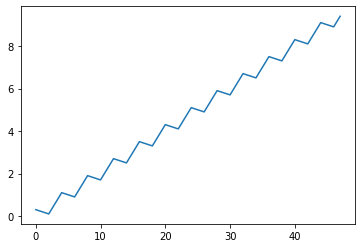

In [31]:
class SimpleTarget(rcp.Lifted):

    def __call__(self, x, length, *args, **kwargs):
        trend = np.arange(length)  
        season = np.asarray([np.cos(2 * np.pi * i * 1/4) for i in range(length)])
        return 0.2 * trend + .3 * season


plt.figure()
plt.plot(SimpleTarget()(None, length=TIME_SERIE_LENGTH))
plt.show()


In [32]:
dataset = ListDataset([{
    "input": 1., 
    "target": SimpleTarget()(x=None, length=TIME_SERIE_LENGTH), 
    "start": "2019-01-07 00:00"} 
    for _ in range(NUMBER_OF_TIME_SERIES)],
    freq=META_DATA.freq)

# Interpretable NBEATs

In [37]:
estimator = NBEATSEstimator(
        freq=META_DATA.freq,
        prediction_length=META_DATA.prediction_length,
        context_length=META_DATA.prediction_length * 3,
        trainer=Trainer(device="cpu",
                        epochs=NUM_EPOCHS,
                        learning_rate=5e-3,
                        num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
                        batch_size=BATCH_SIZE,
                        ),
        num_stacks=2,
        num_blocks=[3],
        num_block_layers=[4],
        stack_types=["T", "S"],
        widths=[256, 2048],
        sharing=[True],
        expansion_coefficient_lengths=[3]
    )
predictor = estimator.train(dataset)
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset,  # test dataset
    predictor=predictor,  # predictor
    num_samples=NUM_SAMPLES,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset))
    

31it [00:00, 168.31it/s]
0it [00:06, ?it/s, avg_epoch_loss=120, epoch=0]
31it [00:00, 213.19it/s]
0it [00:06, ?it/s, avg_epoch_loss=18.4, epoch=1]
31it [00:00, 212.21it/s]
0it [00:06, ?it/s, avg_epoch_loss=34, epoch=2]
31it [00:00, 230.26it/s]
0it [00:06, ?it/s, avg_epoch_loss=109, epoch=3]
31it [00:00, 147.01it/s]
0it [00:06, ?it/s, avg_epoch_loss=85.5, epoch=4]
31it [00:00, 194.55it/s]
0it [00:06, ?it/s, avg_epoch_loss=57.9, epoch=5]
31it [00:00, 201.39it/s]
0it [00:05, ?it/s, avg_epoch_loss=112, epoch=6]
31it [00:00, 176.76it/s]
0it [00:05, ?it/s, avg_epoch_loss=2.38e+5, epoch=7]
31it [00:00, 212.92it/s]
0it [00:06, ?it/s, avg_epoch_loss=6.2e+7, epoch=8]
31it [00:00, 176.69it/s]
0it [00:06, ?it/s, avg_epoch_loss=2.19e+8, epoch=9]
31it [00:00, 199.58it/s]
0it [00:05, ?it/s, avg_epoch_loss=8.08e+10, epoch=10]
31it [00:00, 218.63it/s]
0it [00:08, ?it/s, avg_epoch_loss=1.6e+7, epoch=11]
31it [00:00, 229.57it/s]
0it [00:08, ?it/s, avg_epoch_loss=6.18e+9, epoch=12]
31it [00:00, 176.26it/s

In [38]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 41188.423095703125,
    "abs_error": 309849.859375,
    "abs_target_sum": 18636.80078125,
    "abs_target_mean": 9.100000381469727,
    "seasonal_error": 0.2953488327736079,
    "MASE": 512.2548656351715,
    "MAPE": 16.346373081207275,
    "sMAPE": 1.73826302587986,
    "OWA": NaN,
    "MSIS": 20490.19390211622,
    "QuantileLoss[0.1]": 75393.1103515625,
    "Coverage[0.1]": 0.25,
    "QuantileLoss[0.2]": 134007.298828125,
    "Coverage[0.2]": 0.25,
    "QuantileLoss[0.3]": 192621.48730468756,
    "Coverage[0.3]": 0.25,
    "QuantileLoss[0.4]": 251235.67578125006,
    "Coverage[0.4]": 0.25,
    "QuantileLoss[0.5]": 309849.8642578125,
    "Coverage[0.5]": 0.25,
    "QuantileLoss[0.6]": 368464.0527343751,
    "Coverage[0.6]": 0.25,
    "QuantileLoss[0.7]": 427078.2412109374,
    "Coverage[0.7]": 0.25,
    "QuantileLoss[0.8]": 485692.4296875001,
    "Coverage[0.8]": 0.25,
    "QuantileLoss[0.9]": 544306.6181640624,
    "Coverage[0.9]": 0.25,
    "RMSE": 202.94931164136312,
 

# Generic NBEATs

In [35]:
estimator = NBEATSEstimator(
        freq=META_DATA.freq,
        prediction_length=META_DATA.prediction_length,
        context_length=META_DATA.prediction_length * 3,
        trainer=Trainer(device="cpu",
                        epochs=NUM_EPOCHS,
                        learning_rate=1e-3,
                        num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
                        batch_size=BATCH_SIZE,
                        ),
        num_stacks=30,
        num_blocks=[1],
        num_block_layers=[4],
        stack_types=["G"],
        widths=[512],
        sharing=[False],
        expansion_coefficient_lengths=[32]
    )
predictor = estimator.train(dataset)
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset,  # test dataset
    predictor=predictor,  # predictor
    num_samples=NUM_SAMPLES,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset))

31it [00:00, 287.28it/s]
0it [00:05, ?it/s, avg_epoch_loss=8.08, epoch=0]
31it [00:00, 259.08it/s]
0it [00:04, ?it/s, avg_epoch_loss=2.99, epoch=1]
31it [00:00, 260.77it/s]
0it [00:04, ?it/s, avg_epoch_loss=2.88, epoch=2]
31it [00:00, 251.13it/s]
0it [00:04, ?it/s, avg_epoch_loss=3.22, epoch=3]
31it [00:00, 259.39it/s]
0it [00:04, ?it/s, avg_epoch_loss=3.69, epoch=4]
31it [00:00, 247.51it/s]
0it [00:04, ?it/s, avg_epoch_loss=4.35, epoch=5]
31it [00:00, 165.85it/s]
0it [00:04, ?it/s, avg_epoch_loss=5.86, epoch=6]
31it [00:00, 269.67it/s]
0it [00:04, ?it/s, avg_epoch_loss=184, epoch=7]
31it [00:00, 197.63it/s]
0it [00:04, ?it/s, avg_epoch_loss=145, epoch=8]
31it [00:00, 253.90it/s]
0it [00:04, ?it/s, avg_epoch_loss=86.2, epoch=9]
31it [00:00, 247.37it/s]
0it [00:04, ?it/s, avg_epoch_loss=21.8, epoch=10]
31it [00:00, 262.48it/s]
0it [00:05, ?it/s, avg_epoch_loss=7.78, epoch=11]
31it [00:00, 264.29it/s]
0it [00:04, ?it/s, avg_epoch_loss=3.17, epoch=12]
31it [00:00, 259.54it/s]
0it [00:04, 

In [36]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.000116820268885931,
    "abs_error": 14.12884521484375,
    "abs_target_sum": 18636.80078125,
    "abs_target_mean": 9.100000381469727,
    "seasonal_error": 0.2953488327736079,
    "MASE": 0.02335831206026321,
    "MAPE": 0.0007593978734803386,
    "sMAPE": 0.0007587595682707615,
    "OWA": NaN,
    "MSIS": 0.9343324824105279,
    "QuantileLoss[0.1]": 20.82796630859375,
    "Coverage[0.1]": 0.5,
    "QuantileLoss[0.2]": 19.153186035156253,
    "Coverage[0.2]": 0.5,
    "QuantileLoss[0.3]": 17.47840576171875,
    "Coverage[0.3]": 0.5,
    "QuantileLoss[0.4]": 15.80362548828125,
    "Coverage[0.4]": 0.5,
    "QuantileLoss[0.5]": 14.12884521484375,
    "Coverage[0.5]": 0.5,
    "QuantileLoss[0.6]": 12.45406494140625,
    "Coverage[0.6]": 0.5,
    "QuantileLoss[0.7]": 10.77928466796875,
    "Coverage[0.7]": 0.5,
    "QuantileLoss[0.8]": 9.10450439453125,
    "Coverage[0.8]": 0.5,
    "QuantileLoss[0.9]": 7.42972412109375,
    "Coverage[0.9]": 0.5,
    "RMSE": 0.010808342559